In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data

sess = tf.InteractiveSession()

mb_size = 128
Z_dim = 100

In [1]:
mnist = input_data.read_data_sets('./data/MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def weight_var(shape, name):
    return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())


def bias_var(shape, name):
    return tf.get_variable(name=name, shape=shape, initializer=tf.constant_initializer(0))


# discriminater net

X = tf.placeholder(tf.float32, shape=[None, 784], name='X')

D_W1 = weight_var([784, 128], 'D_W1')
D_b1 = bias_var([128], 'D_b1')

D_W2 = weight_var([128, 1], 'D_W2')
D_b2 = bias_var([1], 'D_b2')


theta_D = [D_W1, D_W2, D_b1, D_b2]


# generator net

Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

G_W1 = weight_var([100, 128], 'G_W1')
G_b1 = bias_var([128], 'G_B1')

G_W2 = weight_var([128, 784], 'G_W2')
G_b2 = bias_var([784], 'G_B2')

theta_G = [G_W1, G_W2, G_b1, G_b2]
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
D_optimizer = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_optimizer = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])

sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
for it in range(10000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={
                              X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={
                              Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it),
              'D loss: {:.4}'.format(D_loss_curr), 
              'G_loss: {:.4}'.format(G_loss_curr))

Iter: 0 D loss: 1.501 G_loss: 2.398
Iter: 1000 D loss: 0.02053 G_loss: 6.749
Iter: 2000 D loss: 0.07285 G_loss: 5.144
Iter: 3000 D loss: 0.1927 G_loss: 5.546
Iter: 4000 D loss: 0.1536 G_loss: 4.8
Iter: 5000 D loss: 0.2518 G_loss: 4.739
Iter: 6000 D loss: 0.2418 G_loss: 3.371
Iter: 7000 D loss: 0.4397 G_loss: 3.515
Iter: 8000 D loss: 0.3669 G_loss: 2.932
Iter: 9000 D loss: 0.4245 G_loss: 3.447


In [8]:
def get_shape(tensor):
    static_shape = tensor.shape.as_list()
    dynamic_shape = tf.unstack(tf.shape(tensor))
    dims = [s[1] if s[0] is None else s[0]
          for s in zip(static_shape, dynamic_shape)]
    return dims

choose = tf.placeholder(tf.int64,[None,5])
minValue = tf.placeholder(tf.int64,[None,1])
ex=6
feed_dict = {
    choose:[[5,4,3,0,1],[2,3,0,4,2],[2,3,5,4,2]],
    minValue:[[3],[2],[2]]}

x = tf.tile(tf.reshape(tf.arg_max(tf.cast(choose<minValue,tf.int64),1),(-1,1)),[1,5])
y = tf.tile(tf.reduce_sum(tf.cast(choose<minValue,tf.int64),axis=1,keep_dims=True),[1,5])
index = tf.tile(tf.expand_dims(tf.range(5,dtype=tf.int64),0),[get_shape(choose)[0],1])
result = tf.where(index<x,choose,tf.zeros_like(choose))
result = tf.where(index<x,choose,tf.zeros_like(choose)) + tf.where(tf.equal(y,0),choose,tf.zeros_like(choose))
sess =tf.Session()
def see(x):
    print(sess.run(x, feed_dict))

see(result)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
[[5 4 3 0 0]
 [2 3 0 0 0]
 [2 3 5 4 2]]


In [28]:
a = tf.placeholder(tf.int32,[None, None, 5])


batch = tf.shape(a)[0]
size = tf.shape(a)[1]

b = tf.zeros([batch, 6, 5], dtype=tf.int32)

d = tf.slice(a, [0, 0, 0], [batch, size, 5])
e = tf.slice(b, [0, 0, 0], [batch, 6-size, 5])
f = tf.concat([d,e],1)
g = tf.reshape(f, [-1, 6, 5])
print(g.shape)
print(sess.run(g, {a:[[[5,4,3,0,1],[2,3,0,4,2],[2,3,5,4,2]]]}))

(?, 6, 5)
[[[5 4 3 0 1]
  [2 3 0 4 2]
  [2 3 5 4 2]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]


In [6]:
x = tf.placeholder(tf.float32, shape=(2, 2), name="input")
xx=tf.zeros([2,3],tf.float32)
xx2=tf.concat([x,xx],axis=1)
columnTensor=tf.ones([2,1],tf.float32)
print (xx2)
w1= tf.Variable(tf.random_normal([2, 3], stddev=1, seed=1),trainable=False)
w2= tf.Variable(xx2,trainable=False)
#编写程序修改Tensor矩阵的某一列
embed_size=300
max_sentence_length=50
max_node_size=max_sentence_length*2-1#训练语料库句子节点的最大长度。注意，是句子节点的最大长度。不是句子单词的最大数目。
def modify_one_column(tensor,columnTensor,index):#index也是tensor
#tensor为二维矩阵
#columnTensor的维度就是tensor中的一列
    numlines=tensor.shape[0].value #行数
    numcolunms=tensor.shape[1].value #列数
    new_tensor_left=tf.slice(tensor, [0, 0], [numlines, index])
    new_tensor_right=tf.slice(tensor, [0, index+1], [numlines, numcolunms-(index+1)])
    new_tensor=tf.concat([new_tensor_left,columnTensor,new_tensor_right],1)
    return new_tensor_left,new_tensor_right,new_tensor

sess = tf.Session()
init_op = tf.global_variables_initializer()  
#print(sess.run(x, feed_dict={x: [[0.7,0.9]]}))
sess.run(init_op,feed_dict={x: [[0.7,0.9],[80.0,90.0]]})
print (sess.run((w1,w2)))
print (w2)
for index in range(5):
    index_tensor=tf.constant(index,tf.int32)
    new_tensor_left,new_tensor_right,w22=modify_one_column(w2,columnTensor,index_tensor)
    print (sess.run([new_tensor_left,columnTensor,new_tensor_right,w22]))
for index in range(5):
    index_tensor=tf.constant(index,tf.int32)
    new_tensor_left,new_tensor_right,w2=modify_one_column(w2,columnTensor,index_tensor)
    print (sess.run([new_tensor_left,columnTensor,new_tensor_right,w2]))
#print (sess.run(w2,feed_dict={x: [[0.7,0.9]]}))

Tensor("concat:0", shape=(2, 5), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
(array([[-0.8113182 ,  1.4845988 ,  0.06532937],
       [-2.4427042 ,  0.0992484 ,  0.5912243 ]], dtype=float32), array([[ 0.7,  0.9,  0. ,  0. ,  0. ],
       [80. , 90. ,  0. ,  0. ,  0. ]], dtype=float32))
<tf.Variable 'Variable_1:0' shape=(2, 5) dtype=float32_ref>
[array([], shape=(2, 0), dtype=float32), array([[1.],
       [1.]], dtype=float32), array([[ 0.9,  0. ,  0. ,  0. ],
       [90. ,  0. ,  0. ,  0. ]], dtype=float32), array([[ 1. ,  0.9,  0. ,  0. ,  0. ],
       [ 1. , 90. ,  0. ,  0. ,  0. ]], dtype=float32)]
[array([[ 0.7],
       [80. ]], dtype=float32), array([[1.],
       [1.]], dtype=float32), array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), array([[ 0.7,  1. ,  0. ,  0. ,  0. ],
       [80. ,  1. ,  0. ,  0. ,  0. ]], dtype=float32)]
[array([[ 0.7,  0.9],
       [80. , 90. ]], dtype=float32), array([[1.],
       [1.]], dtype=float32), a

In [17]:
import numpy as np
a = np.array([[[5,4,3,0,1],[2,3,0,4,2],[2,3,5,4,2]]])
b = np.zeros([1, 6, 5])
b[:,:,:]=a[:,:,:]
b

ValueError: could not broadcast input array from shape (1,3,5) into shape (1,6,5)

In [4]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):  # [i,samples[i]] imax=16
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [5]:
if not os.path.exists('out/'):
    os.makedirs('out/')

Iter: 0 D loss: 1.544 G_loss: 2.342
Iter: 1000 D loss: 0.02131 G_loss: 5.716
Iter: 2000 D loss: 0.04296 G_loss: 5.928
Iter: 3000 D loss: 0.1877 G_loss: 4.682
Iter: 4000 D loss: 0.1888 G_loss: 4.941
Iter: 5000 D loss: 0.31 G_loss: 5.372
Iter: 6000 D loss: 0.2874 G_loss: 4.947
Iter: 7000 D loss: 0.4094 G_loss: 4.192
Iter: 8000 D loss: 0.2166 G_loss: 4.171
Iter: 9000 D loss: 0.4293 G_loss: 4.104
Iter: 10000 D loss: 0.4423 G_loss: 3.256
Iter: 11000 D loss: 0.495 G_loss: 2.984
Iter: 12000 D loss: 0.4791 G_loss: 4.471
Iter: 13000 D loss: 0.8266 G_loss: 3.148
Iter: 14000 D loss: 0.7278 G_loss: 3.156
Iter: 15000 D loss: 0.6981 G_loss: 1.802
Iter: 16000 D loss: 0.8532 G_loss: 2.315
Iter: 17000 D loss: 0.726 G_loss: 1.827
Iter: 18000 D loss: 0.8994 G_loss: 1.944
Iter: 19000 D loss: 0.7799 G_loss: 1.877
Iter: 20000 D loss: 0.713 G_loss: 2.182
Iter: 21000 D loss: 0.7728 G_loss: 2.119
Iter: 22000 D loss: 0.9354 G_loss: 1.81
Iter: 23000 D loss: 0.8594 G_loss: 1.974
Iter: 24000 D loss: 0.9692 G_loss:

Iter: 199000 D loss: 0.6608 G_loss: 2.704
Iter: 200000 D loss: 0.592 G_loss: 2.709
Iter: 201000 D loss: 0.5032 G_loss: 2.96
Iter: 202000 D loss: 0.5221 G_loss: 2.42
Iter: 203000 D loss: 0.4931 G_loss: 2.512
Iter: 204000 D loss: 0.4904 G_loss: 2.255
Iter: 205000 D loss: 0.5094 G_loss: 2.958
Iter: 206000 D loss: 0.5405 G_loss: 2.373
Iter: 207000 D loss: 0.5446 G_loss: 2.452
Iter: 208000 D loss: 0.58 G_loss: 2.404
Iter: 209000 D loss: 0.458 G_loss: 2.535
Iter: 210000 D loss: 0.5119 G_loss: 2.618
Iter: 211000 D loss: 0.4609 G_loss: 2.385
Iter: 212000 D loss: 0.6054 G_loss: 2.331
Iter: 213000 D loss: 0.4997 G_loss: 2.756
Iter: 214000 D loss: 0.6896 G_loss: 2.615
Iter: 215000 D loss: 0.5326 G_loss: 2.124
Iter: 216000 D loss: 0.6012 G_loss: 2.353
Iter: 217000 D loss: 0.532 G_loss: 2.781
Iter: 218000 D loss: 0.6329 G_loss: 2.646
Iter: 219000 D loss: 0.5466 G_loss: 2.641
Iter: 220000 D loss: 0.4219 G_loss: 2.57
Iter: 221000 D loss: 0.5124 G_loss: 2.584
Iter: 222000 D loss: 0.5833 G_loss: 2.384


Iter: 396000 D loss: 0.5249 G_loss: 3.176
Iter: 397000 D loss: 0.4017 G_loss: 3.373
Iter: 398000 D loss: 0.3934 G_loss: 2.77
Iter: 399000 D loss: 0.5815 G_loss: 3.391
Iter: 400000 D loss: 0.3384 G_loss: 2.761
Iter: 401000 D loss: 0.4027 G_loss: 2.875
Iter: 402000 D loss: 0.5267 G_loss: 2.944
Iter: 403000 D loss: 0.4381 G_loss: 2.985
Iter: 404000 D loss: 0.3429 G_loss: 3.268
Iter: 405000 D loss: 0.4041 G_loss: 2.813
Iter: 406000 D loss: 0.4559 G_loss: 2.761
Iter: 407000 D loss: 0.4998 G_loss: 2.847
Iter: 408000 D loss: 0.3892 G_loss: 3.48
Iter: 409000 D loss: 0.3632 G_loss: 3.003
Iter: 410000 D loss: 0.3065 G_loss: 2.731
Iter: 411000 D loss: 0.4013 G_loss: 2.858
Iter: 412000 D loss: 0.382 G_loss: 3.048
Iter: 413000 D loss: 0.5001 G_loss: 2.688
Iter: 414000 D loss: 0.4133 G_loss: 3.136
Iter: 415000 D loss: 0.4601 G_loss: 2.818
Iter: 416000 D loss: 0.4819 G_loss: 2.873
Iter: 417000 D loss: 0.3763 G_loss: 3.038
Iter: 418000 D loss: 0.3783 G_loss: 3.192
Iter: 419000 D loss: 0.3531 G_loss: 2

KeyboardInterrupt: 

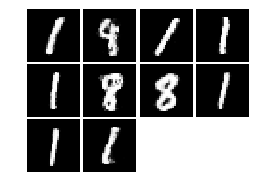

In [6]:
sess.run(tf.global_variables_initializer())

i = 0
for it in range(1000000):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={
                           Z: sample_Z(16, Z_dim)})  # 16*784
        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={
                              X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={
                              Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it),
              'D loss: {:.4}'.format(D_loss_curr), 
              'G_loss: {:.4}'.format(G_loss_curr))